In [1]:
import os, sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import itertools
%matplotlib inline 

import torch
import torch.nn as nn
import torchvision
import gc
import random
import seaborn as sns
import torchvision.datasets as datasets
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, TensorDataset
from src import distributions
from src.tools import unfreeze, freeze
from src.tools import weights_init_D
from src.tools import fig2data, fig2img
from src.guided_samplers import Sampler, PairedSubsetSampler, SubsetGuidedDataset, get_indicies_subset
from src.gaussian_utils import generate_data, plot_gaussian, build_dataloader
from tqdm import tqdm_notebook as tqdm

## Init Parameters

In [2]:
NUM_LABELED = 10
T_ITERS = 10
BATCH_SIZE = 32
С_SIZE = 2
#real batch size is BATCH_SIZE*С_SIZE
NUM_MODES = 4

D_LR, T_LR = 1e-3, 1e-3
PLOT_INTERVAL = 100
CPKT_INTERVAL = 1000
MAX_STEPS = 1001 #increase if you need better results
SEED = 0x000001
torch.manual_seed(SEED); np.random.seed(SEED)

## Build ClassGuided Gaussian Datasets

In [3]:
source_data = generate_data(num_mode = NUM_MODES, coordinates = [0,6], num_data_per_class=10000)
target_data = generate_data(num_mode = NUM_MODES, coordinates = [0,6], num_data_per_class=10000)
source_train, source_loader = build_dataloader(source_data)
target_train, target_loader = build_dataloader(target_data)

In [4]:
source_classes = torch.tensor(list(range(0,NUM_MODES*NUM_MODES)))
source_labels = {i.item():i.item() for i in source_classes}

#rundomly shuffle the target dataset labels
random_order_classes = list(range(0,NUM_MODES*NUM_MODES))
random.shuffle(random_order_classes)
target_classes = torch.tensor(list(range(0,NUM_MODES*NUM_MODES)))
new_target_labels = {i.item():j for i,j in zip(target_classes,random_order_classes)}

In [5]:
subset_samples, labels, source_class_indicies = get_indicies_subset(source_train, 
                                                                    new_labels = source_labels, 
                                                                    classes=len(source_classes), 
                                                                    subset_classes=source_classes)
source_train = TensorDataset(torch.stack(subset_samples), torch.LongTensor(labels))

target_subset_samples, target_labels, target_class_indicies = get_indicies_subset(target_train, 
                                                                                  new_labels = new_target_labels, 
                                                                                  classes=len(target_classes), 
                                                                                  subset_classes=target_classes)
target_train = TensorDataset(torch.stack(target_subset_samples), torch.LongTensor(target_labels))

train_set = SubsetGuidedDataset(source_train, target_train, 
                                num_labeled=NUM_LABELED, 
                                in_indicies = source_class_indicies, 
                                out_indicies = target_class_indicies)

full_set = SubsetGuidedDataset(source_train, target_train, 
                               num_labeled='all', 
                               in_indicies = source_class_indicies, 
                               out_indicies = target_class_indicies)
T_XY_sampler = PairedSubsetSampler(train_set, subsetsize=С_SIZE)
D_XY_sampler = PairedSubsetSampler(full_set, subsetsize=1)

## Source

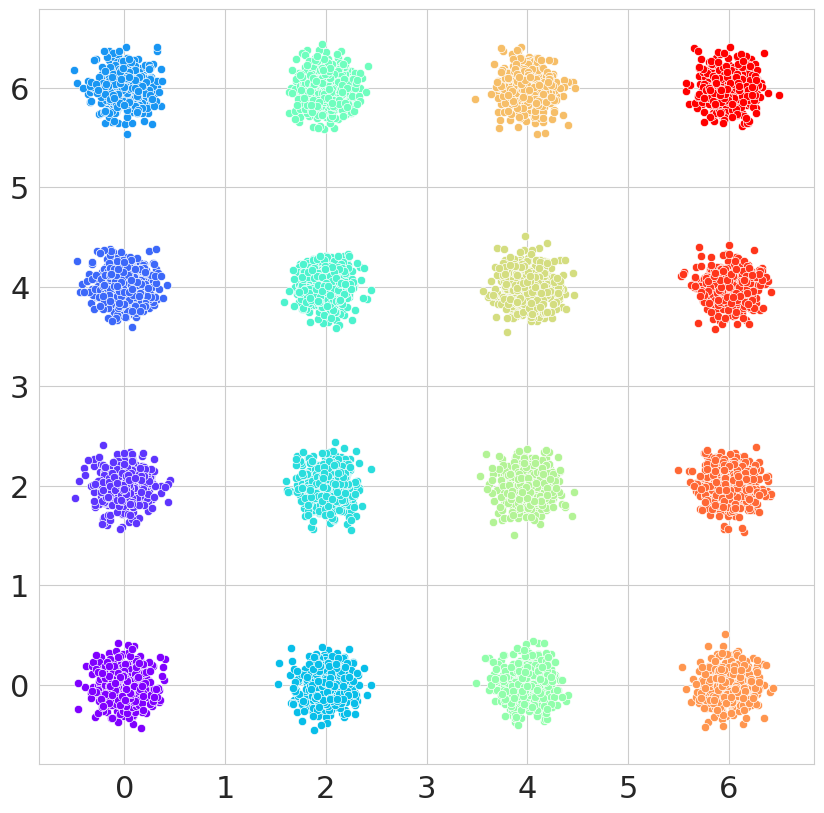

In [6]:
plot_gaussian(num_mode=4, coordinates = [0,6], num_data_per_class=500, labels=source_labels)

## Target

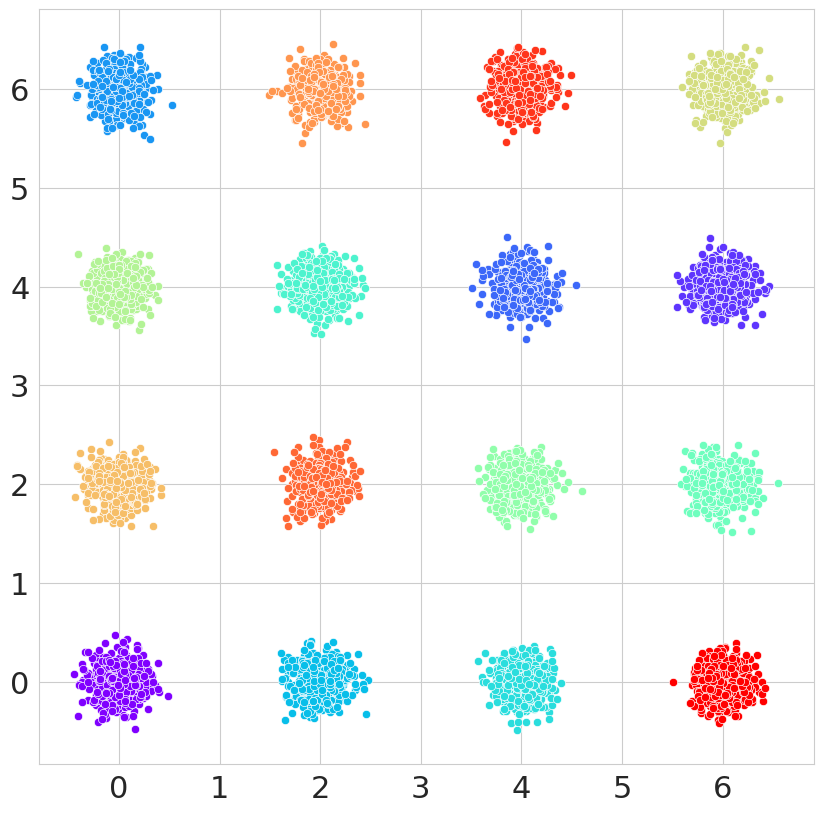

In [7]:
plot_gaussian(num_mode=4, coordinates = [0,6], num_data_per_class=500, labels=new_target_labels)

## Init Networks

In [8]:
class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

T = FeedForward(2, 256, 2).cuda()
D = FeedForward(2, 256, 1).cuda()
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
D_opt = torch.optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)

## Start Training

  0%|          | 0/1001 [00:00<?, ?it/s]

Loss: 2.8115427494049072
step: 0


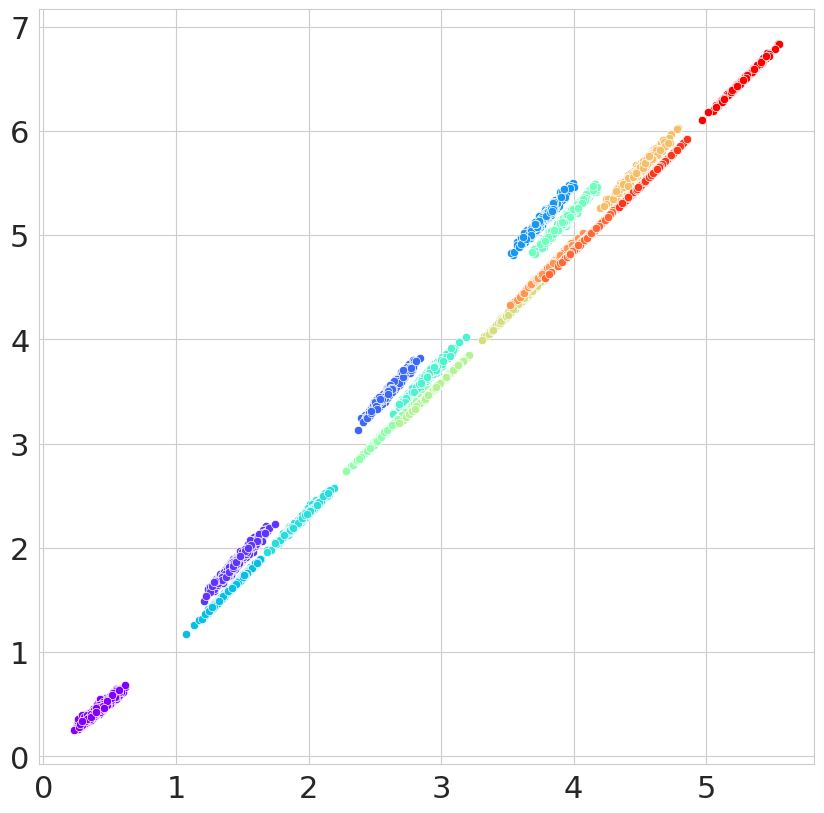

Loss: 0.4772879481315613
step: 100


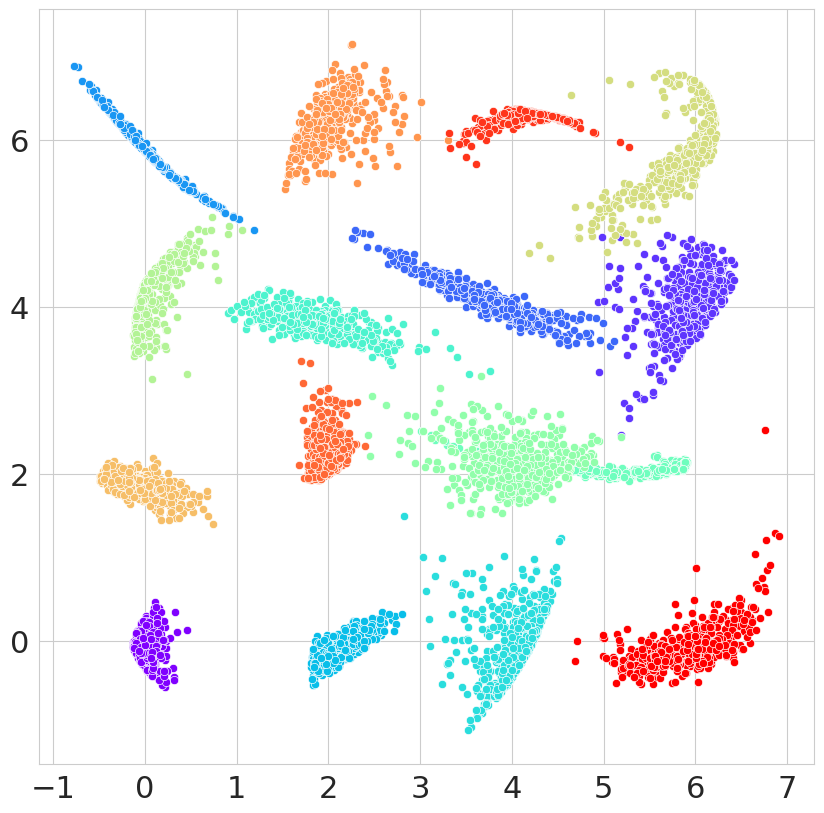

Loss: -0.2456943839788437
step: 200


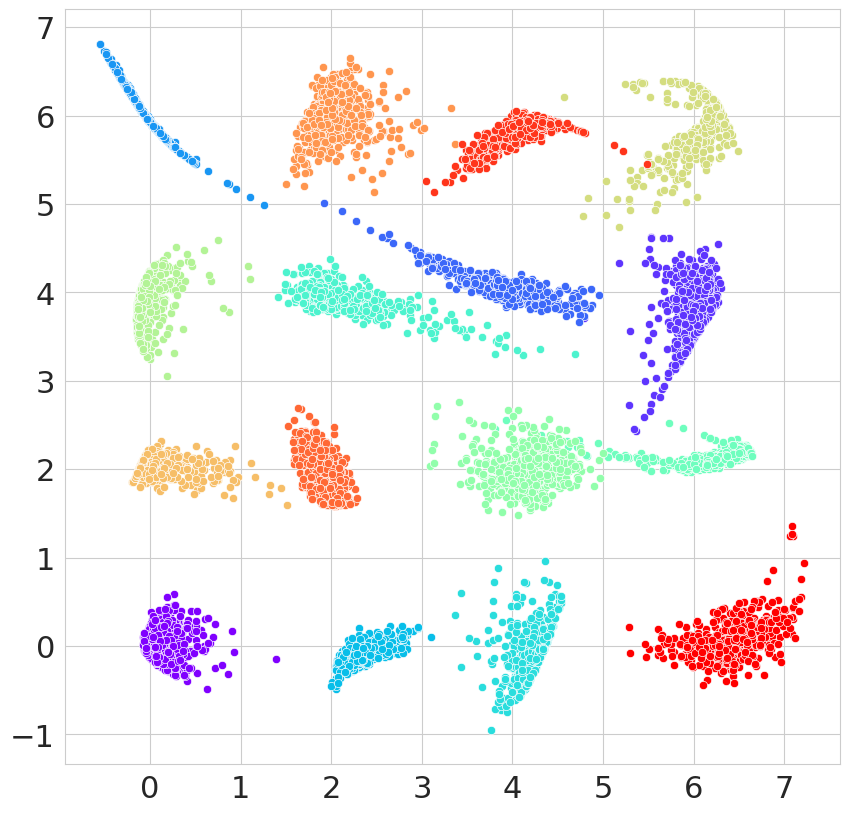

Loss: 0.5730064511299133
step: 300


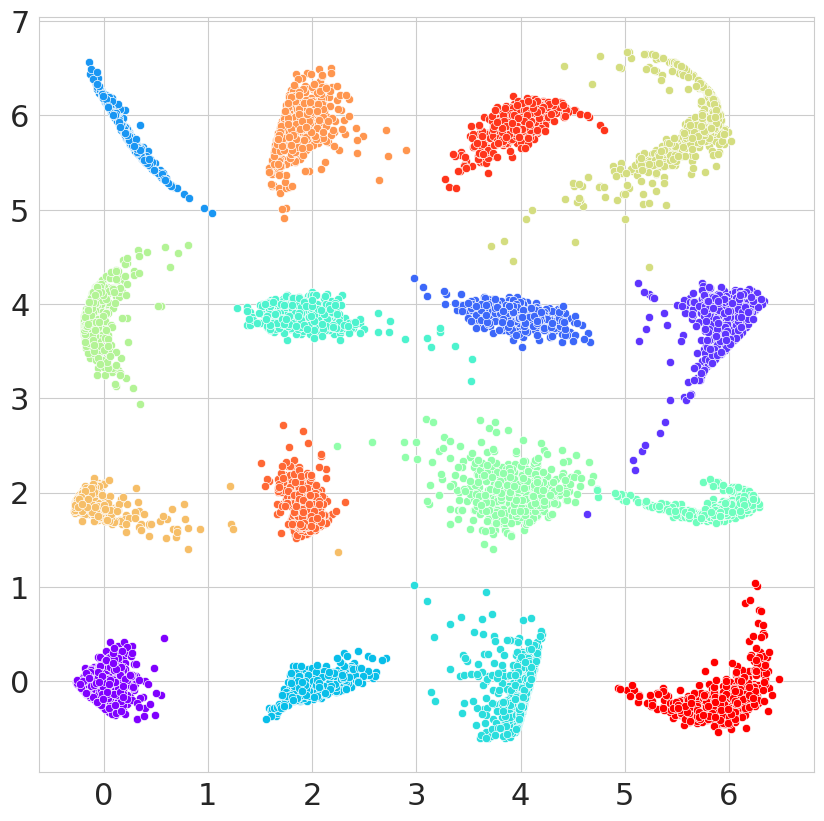

Loss: 0.01596154272556305
step: 400


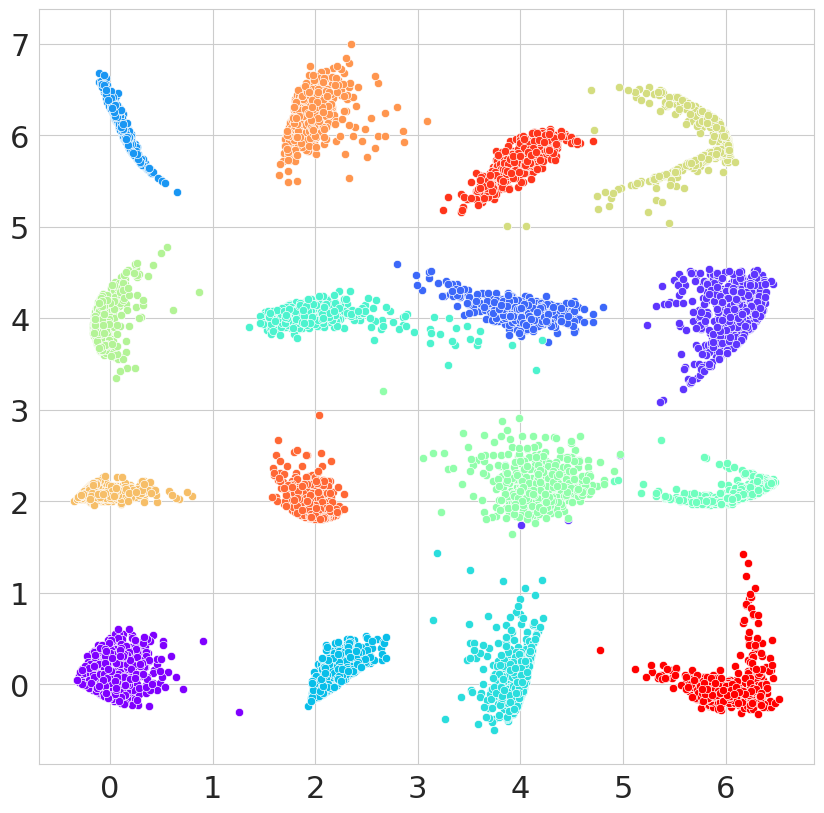

Loss: 0.09346999228000641
step: 500


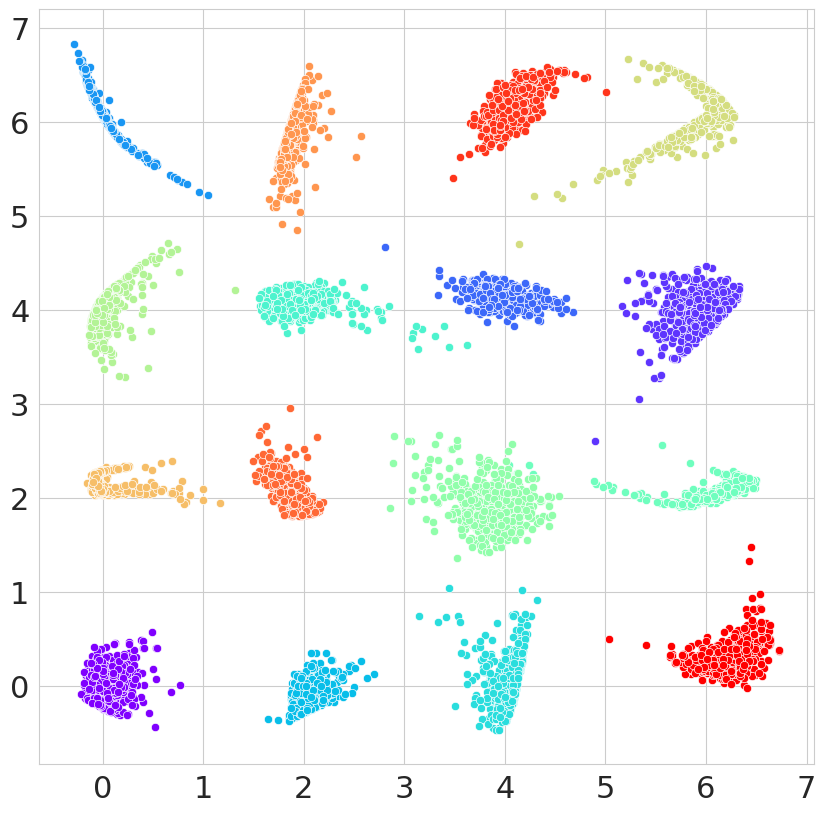

Loss: 0.45077311992645264
step: 600


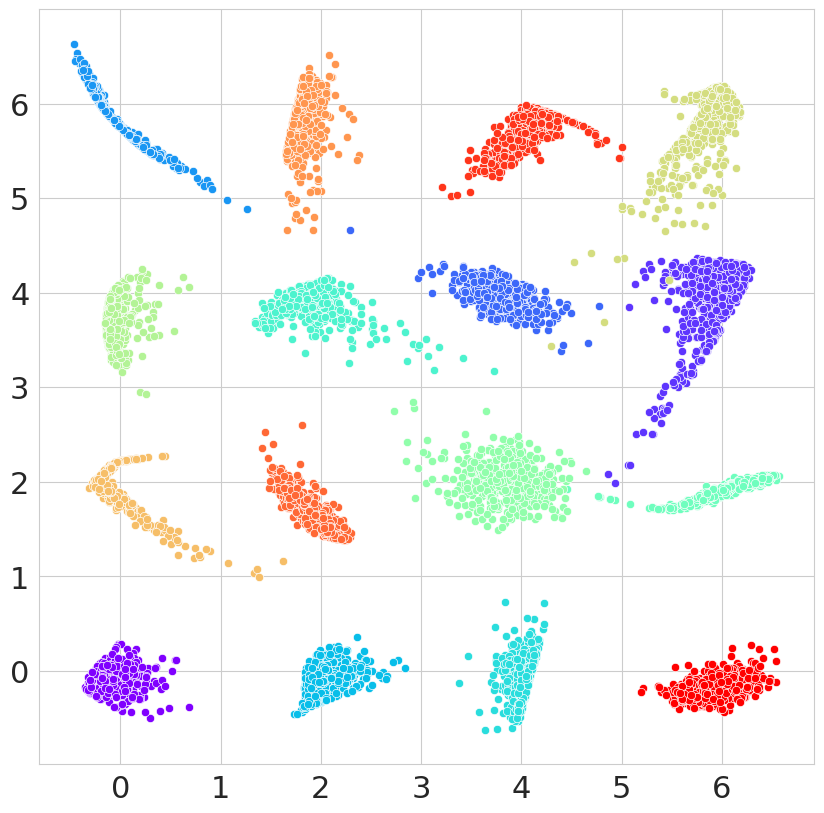

Loss: -0.1843986213207245
step: 700


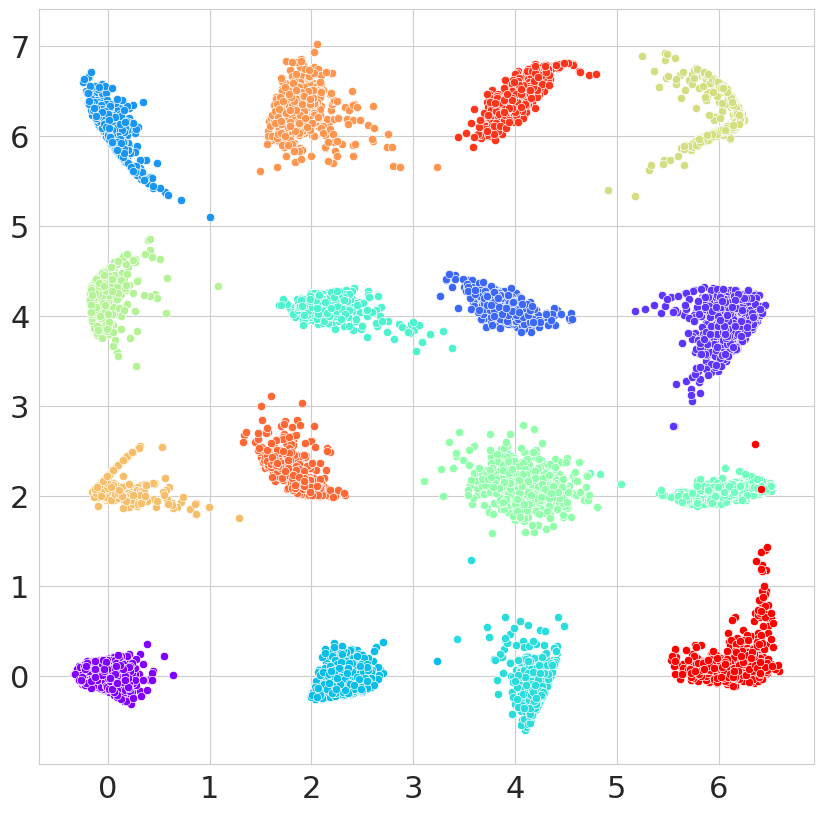

Loss: -0.007673516869544983
step: 800


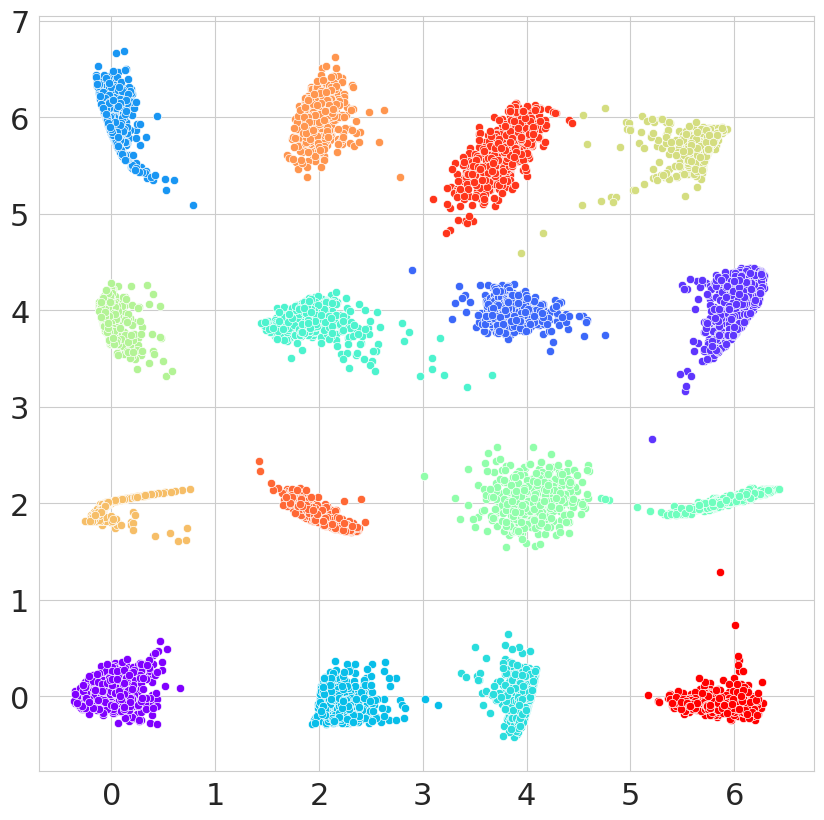

Loss: 0.1480204313993454
step: 900


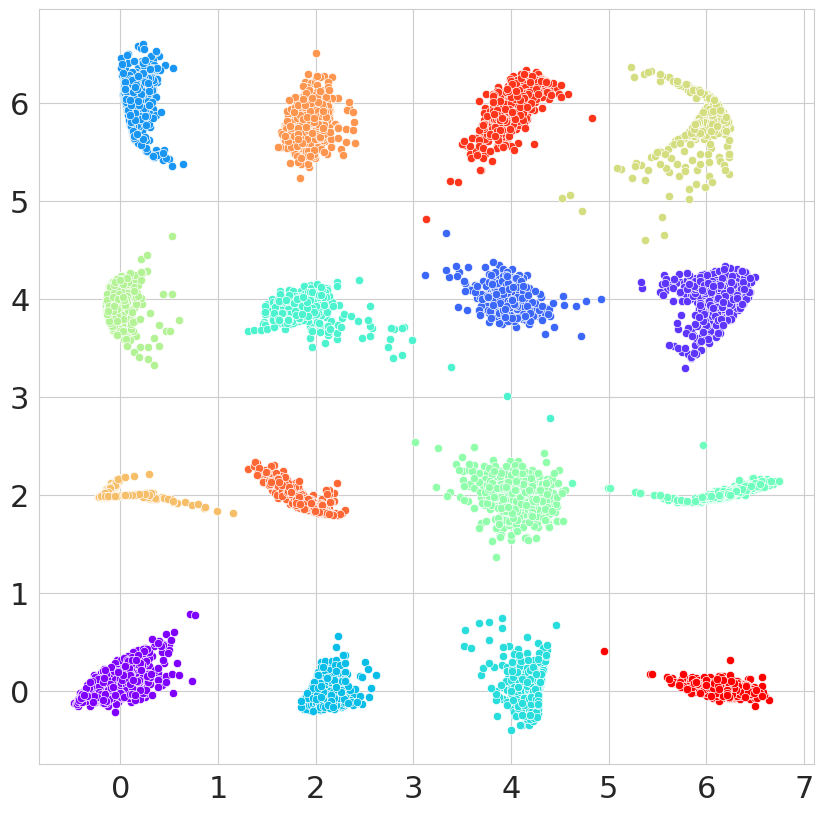

Loss: -0.07280202209949493
step: 1000


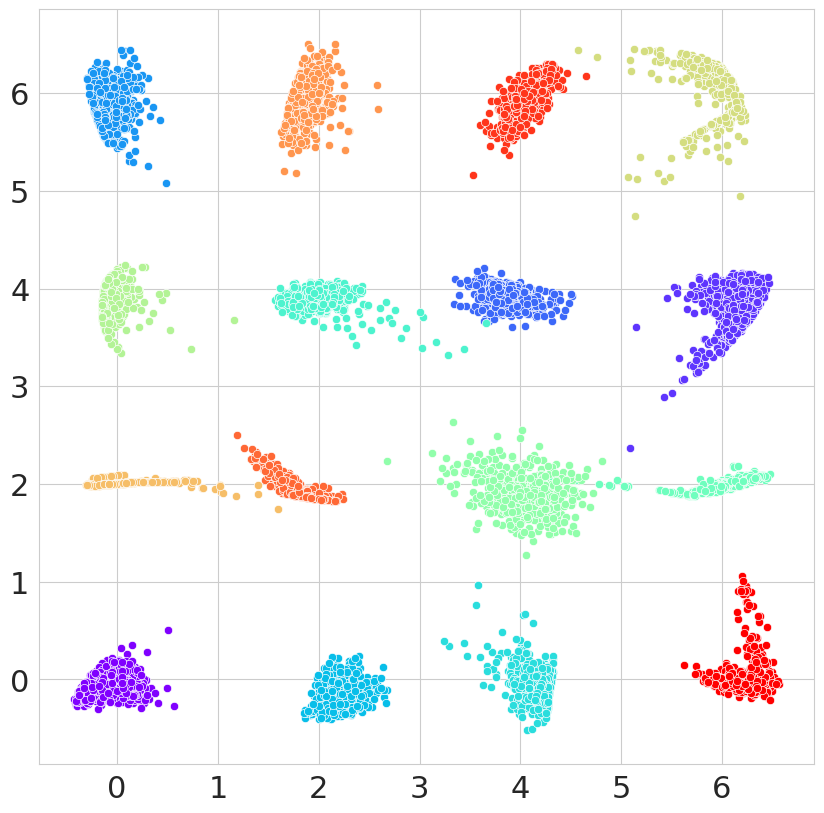

In [10]:
for step in tqdm(range(MAX_STEPS)):
    unfreeze(T); freeze(D)
    for t_iter in range(T_ITERS): 
        T_opt.zero_grad()
        X, Y = T_XY_sampler.sample(BATCH_SIZE)
        T_X = T(X.flatten(start_dim=0, end_dim=1)).permute(1,0).reshape(2, -1, С_SIZE).permute(1,2,0)    
        T_var = .5 * torch.cdist(T_X, T_X).mean() * С_SIZE / (С_SIZE -1)
        cost = (Y-T_X).norm(dim=2).mean()
        T_loss = cost - T_var - D(T_X.flatten(start_dim=0, end_dim=1)).mean()
        T_loss.backward(); T_opt.step()
        
    del T_X, X, Y, T_var; gc.collect(); torch.cuda.empty_cache() 

    freeze(T); unfreeze(D)
    X, _ = T_XY_sampler.sample(BATCH_SIZE)
    _, Y = D_XY_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        T_X = T(X.flatten(start_dim=0, end_dim=1)) 
    Y = torch.squeeze(Y)
    D_opt.zero_grad()
    D_loss = D(T_X).mean() - D(Y).mean()
    D_loss.backward(); D_opt.step();
    
    if step % PLOT_INTERVAL == 0:
        print('Loss:', T_loss.item())
        print('step:', step)
        plot_gaussian(model=T, num_mode=4, coordinates = [0,6], num_data_per_class=500)
    del D_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()